Imports

In [1]:

import os
import numpy as np

from PIL import Image 

import tensorflow as tf
from tensorflow.keras import backend  
from tensorflow.keras import layers         
from tensorflow.keras import models         
from tensorflow.keras import regularizers   
from tensorflow.keras.layers import Input,  GlobalAveragePooling2D, concatenate, BatchNormalization

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

2025-05-10 22:49:20.286423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading the Data ```Spectograms & MFCC```

In [2]:
SPECTROGRAM_BASE_DIR = '/home/madan005/dev/deeplearning/Spectrogram'
MFCC_IMAGE_BASE_DIR = '/home/madan005/dev/deeplearning/MFCC'

SPECTROGRAM_FILE_EXTENSION = '.png' 
MFCC_IMAGE_FILE_EXTENSION = '.png'  

# Spectrogram paths
train_spectrogram_base = os.path.join(SPECTROGRAM_BASE_DIR, 'train')
validation_spectrogram_base = os.path.join(SPECTROGRAM_BASE_DIR, 'dev')
test_spectrogram_base = os.path.join(SPECTROGRAM_BASE_DIR, 'eval')

# MFCC paths
train_mfcc_image_base = os.path.join(MFCC_IMAGE_BASE_DIR, 'train')
validation_mfcc_image_base = os.path.join(MFCC_IMAGE_BASE_DIR, 'dev')
test_mfcc_image_base = os.path.join(MFCC_IMAGE_BASE_DIR, 'eval')

'''
 Loads paired spectrogram and MFCC images from the specified folders, converts them to RGB NumPy arrays, and returns them with a shared label.
 Skips any missing or unreadable files and logs warnings for each skipped sample.
'''

def load_dual_image_data_from_folders(spec_class_folder, mfcc_img_class_folder, label, target_size, spec_ext, mfcc_img_ext):
    spectrograms_out = []
    mfcc_images_out = []
    labels_out = []
    spec_filenames = sorted(os.listdir(spec_class_folder))

    for spec_filename_with_ext in spec_filenames:
        if not spec_filename_with_ext.lower().endswith(spec_ext.lower()):
            continue 
        base_filename = os.path.splitext(spec_filename_with_ext)[0]
        spec_filepath = os.path.join(spec_class_folder, spec_filename_with_ext)
        mfcc_img_filepath = os.path.join(mfcc_img_class_folder, base_filename + mfcc_img_ext)
        
        # Load Spectrogram 
        try:
            spec_image = Image.open(spec_filepath)
            spec_image = spec_image.convert('RGB') 
            current_spectrogram = np.array(spec_image)
        except Exception as e:
            print(f"Warning: Could not load/process spectrogram {spec_filepath}: {e}. Skipping sample.")
            continue
        
        # Load MFCC 
        try:
            if not os.path.exists(mfcc_img_filepath):
                raise FileNotFoundError(f"MFCC image {mfcc_img_filepath} not found.")
            mfcc_image = Image.open(mfcc_img_filepath)
            mfcc_image = mfcc_image.convert('RGB')
            current_mfcc_image = np.array(mfcc_image)
            spectrograms_out.append(current_spectrogram)
            mfcc_images_out.append(current_mfcc_image)
            labels_out.append(label)

        except Exception as e:
            print(f"Warning: Could not load/process MFCC image for {base_filename} (expected {mfcc_img_filepath}): {e}. Skipping sample.")
            continue
            
    return spectrograms_out, mfcc_images_out, labels_out


X_train_spec, X_train_mfcc_img, y_train = [], [], []
X_val_spec, X_val_mfcc_img, y_val = [], [], []
X_test_spec, X_test_mfcc_img, y_test = [], [], []

data_splits = {
    'train': (train_spectrogram_base, train_mfcc_image_base, X_train_spec, X_train_mfcc_img, y_train),
    'validation': (validation_spectrogram_base, validation_mfcc_image_base, X_val_spec, X_val_mfcc_img, y_val),
    'test': (test_spectrogram_base, test_mfcc_image_base, X_test_spec, X_test_mfcc_img, y_test)
}

for split_name, (spec_base, mfcc_img_base, X_spec_list, X_mfcc_img_list, y_list) in data_splits.items():
    print(f"\nLoading {split_name} data...")
    for class_name in ['genuine', 'spoof']: 
        print(f"  Loading class: {class_name}")
        spectrogram_class_folder = os.path.join(spec_base, class_name)
        mfcc_image_class_folder = os.path.join(mfcc_img_base, class_name)
        label = 1 if class_name == 'genuine' else 0

        spec_data, mfcc_img_data, label_data = load_dual_image_data_from_folders(
            spectrogram_class_folder,
            mfcc_image_class_folder,
            label,
            target_size=(200, 200),
            spec_ext=SPECTROGRAM_FILE_EXTENSION,
            mfcc_img_ext=MFCC_IMAGE_FILE_EXTENSION
        )
        X_spec_list.extend(spec_data)
        X_mfcc_img_list.extend(mfcc_img_data)
        y_list.extend(label_data)



Loading train data...
  Loading class: genuine
  Loading class: spoof

Loading validation data...
  Loading class: genuine
  Loading class: spoof

Loading test data...
  Loading class: genuine
  Loading class: spoof


Pre-training processing

In [3]:
# Normalizing (min max scaling)
X_train_spec = np.array(X_train_spec, dtype='float32') / 255.0
X_val_spec   = np.array(X_val_spec,   dtype='float32') / 255.0
X_test_spec  = np.array(X_test_spec,  dtype='float32') / 255.0

X_train_mfcc_img = np.array(X_train_mfcc_img, dtype='float32') / 255.0
X_val_mfcc_img   = np.array(X_val_mfcc_img,   dtype='float32') / 255.0
X_test_mfcc_img  = np.array(X_test_mfcc_img,  dtype='float32') / 255.0

# Labels
y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

#  Shapes 
print(f"X_train_spec shape: {X_train_spec.shape}, y_train shape: {y_train.shape}")
print(f"X_train_mfcc_img shape: {X_train_mfcc_img.shape}")

print(f"X_val_spec shape: {X_val_spec.shape}, y_val shape: {y_val.shape}")
print(f"X_val_mfcc_img shape: {X_val_mfcc_img.shape}")

print(f"X_test_spec shape: {X_test_spec.shape}, y_test shape: {y_test.shape}")
print(f"X_test_mfcc_img shape: {X_test_mfcc_img.shape}")

# 
if len(y_train) > 0:
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    print("\nTraining set label distribution:")
    for label_val, count in zip(unique_train, counts_train):
        class_name_dist = "genuine" if label_val == 1 else "spoof"
        print(f"- {class_name_dist} (label {label_val}): {count} samples")


X_train_spec shape: (3014, 200, 200, 3), y_train shape: (3014,)
X_train_mfcc_img shape: (3014, 200, 200, 3)
X_val_spec shape: (1710, 200, 200, 3), y_val shape: (1710,)
X_val_mfcc_img shape: (1710, 200, 200, 3)
X_test_spec shape: (13306, 200, 200, 3), y_test shape: (13306,)
X_test_mfcc_img shape: (13306, 200, 200, 3)

Training set label distribution:
- spoof (label 0): 1507 samples
- genuine (label 1): 1507 samples


In [4]:
tf.keras.backend.clear_session() 

IMG_SIZE = (200, 200)
BATCH_SIZE = 32 


# Input Layers
spectrogram_input = layers.Input(shape=(*IMG_SIZE, 3), name='spectrogram_input')
mfcc_image_input = layers.Input(shape=(*IMG_SIZE, 3), name='mfcc_image_input')



# MobileNetV2 Spectrograms 
mobilenet_spec_branch = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg', name='mobilenet_for_spec')
for layer in mobilenet_spec_branch.layers:
    layer._name = layer.name + '_spec'
mobilenet_spec_branch.trainable = False
features_spec = mobilenet_spec_branch(spectrogram_input)  # Input Layer


 # MobileNetV2 MFCC
mobilenet_mfcc_branch = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg', name='mobilenet_for_mfcc')
for layer in mobilenet_mfcc_branch.layers:
    layer._name = layer.name + '_mfcc'
mobilenet_mfcc_branch.trainable = False
features_mfcc = mobilenet_mfcc_branch(mfcc_image_input)


# Concatenate Spectrogram & FCC
concatenated_features = layers.concatenate([features_spec, features_mfcc], name='concatenated_features')


x = layers.Dense(512, activation='relu')(concatenated_features)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)



x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid', name='output')(x)


model = models.Model([spectrogram_input, mfcc_image_input], outputs)



model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'],
    
)

model.summary()

/tmp/ipykernel_4119933/482311067.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_spec_branch = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg', name='mobilenet_for_spec')
/tmp/ipykernel_4119933/482311067.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_mfcc_branch = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg', name='mobilenet_for_mfcc')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mfcc_image_input    │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_for_spec  │ (None, 1280)      │  2,257,984 │ spectrogram_inpu… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_for_mfcc  │ (None, 1280)      │  2,257,984 │ mfcc_image_input… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_featu… │ (None, 2560)      │          0 │ mobilenet_for_sp… │
│ (Concatenate)       │                   │            │ mobilenet_for_mf… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,311,232 │ concatenated_fea… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,978,369 (22.81 MB)

 Trainable params: 1,460,737 (5.57 MB)

 Non-trainable params: 4,517,632 (17.23 MB)

Helper function ```multimodal_data_generator```

In [5]:

def multimodal_data_generator(X1_data, X2_data, Y_data, batch_size, aug1_gen, aug2_gen, shuffle=True):
    """
    Generates batches of augmented data for a dual-input model.
    Spectogram: NumPy array for the first input 
    MFCC: NumPy array for the second input 
    
    """
    num_samples = X1_data.shape[0]
    indices = np.arange(num_samples)
    while True: 
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            if len(batch_indices) == 0: 
                continue

            X1_batch_original = X1_data[batch_indices]
            X2_batch_original = X2_data[batch_indices]
            Y_batch = Y_data[batch_indices]

            
            X1_batch_augmented = np.array([aug1_gen.random_transform(img) for img in X1_batch_original])
            X2_batch_augmented = np.array([aug2_gen.random_transform(img) for img in X2_batch_original])
            
            yield ((X1_batch_augmented, X2_batch_augmented), Y_batch)
            


train_aug_spectrogram = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' 
)

train_aug_mfcc_image = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
if 'y_train' in locals() and not isinstance(y_train, np.ndarray):
    y_train = np.array(y_train)

# Define output signature
output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32, name='spectrogram_image_input'),
     tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32, name='mfcc_image_input')),
    tf.TensorSpec(shape=(None,), dtype=y_train.dtype, name='label')
)

if 'X_train_spec' in locals() and X_train_spec is not None and 'model' in locals(): 
    train_tf_dataset = tf.data.Dataset.from_generator(
        lambda: multimodal_data_generator(X_train_spec, X_train_mfcc_img, y_train, BATCH_SIZE, train_aug_spectrogram, train_aug_mfcc_image, shuffle=True), output_signature=output_signature)
    train_tf_dataset = train_tf_dataset.prefetch(tf.data.AUTOTUNE)
    validation_input_for_fit = ([X_val_spec, X_val_mfcc_img], y_val)

    callbacks_phase1 = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7) 
    ]

    # fitting phase 1
    history_phase1 = model.fit(
        train_tf_dataset,
        steps_per_epoch=8,
        epochs=30, 
        validation_data=validation_input_for_fit,
        callbacks=callbacks_phase1
    )

Epoch 1/30


/home/madan005/miniconda3/envs/my_env/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['spectrogram_input', 'mfcc_image_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5868 - loss: 0.8956 - val_accuracy: 0.5632 - val_loss: 0.6761 - learning_rate: 1.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4979 - loss: 0.9963 - val_accuracy: 0.5819 - val_loss: 0.6616 - learning_rate: 1.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6086 - loss: 0.8006 - val_accuracy: 0.6181 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6251 - loss: 0.7085 - val_accuracy: 0.6509 - val_loss: 0.6324 - learning_rate: 1.0000e-04
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7281 - loss: 0.6320 - val_accuracy: 0.6813 - val_loss: 0.6194 - learning_rate: 1.0000e-04
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7091 - loss: 0.5897 - val_accuracy: 0.6860 - val_loss: 0.6094 - learning_rate: 1.0000e-04
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7419 - loss: 0.5530 - val_accuracy: 0.695

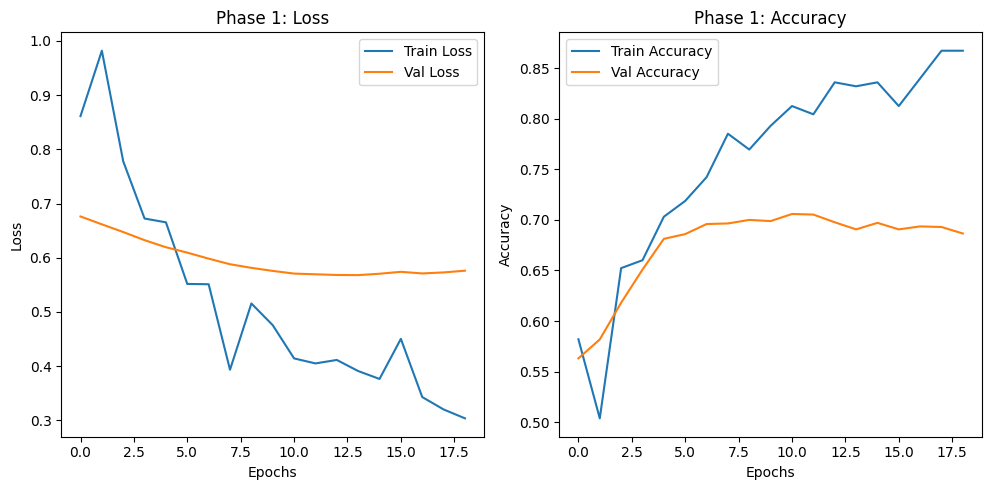

416/416 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - accuracy: 0.5347 - loss: 0.7708


In [7]:
    plt.figure(figsize=(15, 5))

    #  Loss
    plt.subplot(1, 3, 1)
    plt.plot(history_phase1.history['loss'], label='Train Loss')
    plt.plot(history_phase1.history['val_loss'], label='Val Loss')
    plt.title('Phase 1: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history_phase1.history['accuracy'], label='Train Accuracy')
    plt.plot(history_phase1.history['val_accuracy'], label='Val Accuracy')
    plt.title('Phase 1: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
        
    plt.tight_layout()
    plt.show()

    # Evaluate phase 1
    results_phase1 = model.evaluate(
        [X_test_spec, X_test_mfcc_img], y_test,
        batch_size=BATCH_SIZE,
        verbose=1
    )

In [8]:
mobilenet_spec_branch.trainable = True
fine_tune_at_spec = len(mobilenet_spec_branch.layers) - 10 

for layer in mobilenet_spec_branch.layers[:fine_tune_at_spec]:
    layer.trainable = False
print(f"Spectrogram backbone: {len(mobilenet_spec_branch.layers) - fine_tune_at_spec} layers unfrozen.")

mobilenet_mfcc_branch.trainable = True
fine_tune_at_mfcc = len(mobilenet_mfcc_branch.layers) - 10 
for layer in mobilenet_mfcc_branch.layers[:fine_tune_at_mfcc]:
    layer.trainable = False
print(f"MFCC Image backbone: {len(mobilenet_mfcc_branch.layers) - fine_tune_at_mfcc} layers unfrozen.")


# Re-compile the model 
model.compile(
    optimizer=Adam(learning_rate=1e-5 ), loss='binary_crossentropy', metrics=['accuracy'])
model.summary() 

# Callbacks for fine-tuning 
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss', 
        mode='min',        
        patience=6,       
        restore_best_weights=True,
        verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]


Spectrogram backbone: 10 layers unfrozen.
MFCC Image backbone: 10 layers unfrozen.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mfcc_image_input    │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_for_spec  │ (None, 1280)      │  2,257,984 │ spectrogram_inpu… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_for_mfcc  │ (None, 1280)      │  2,257,984 │ mfcc_image_input… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_featu… │ (None, 2560)      │          0 │ mobilenet_for_sp… │
│ (Concatenate)       │                   │            │ mobilenet_for_mf… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,311,232 │ concatenated_fea… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,978,369 (22.81 MB)

 Trainable params: 2,921,857 (11.15 MB)

 Non-trainable params: 3,056,512 (11.66 MB)

In [9]:
history_phase2 = model.fit(
    train_tf_dataset,
    steps_per_epoch=8,
    epochs=20, 
    validation_data=validation_input_for_fit,
    callbacks=callbacks_phase2,
    )

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7519 - loss: 0.4899 - val_accuracy: 0.6942 - val_loss: 0.5629 - learning_rate: 1.0000e-05
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7809 - loss: 0.4564 - val_accuracy: 0.7006 - val_loss: 0.5585 - learning_rate: 1.0000e-05
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7034 - loss: 0.6363 - val_accuracy: 0.7076 - val_loss: 0.5553 - learning_rate: 1.0000e-05
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7577 - loss: 0.5282 - val_accuracy: 0.7140 - val_loss: 0.5530 - learning_rate: 1.0000e-05
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8163 - loss: 0.4162 - val_accuracy: 0.7170 - val_loss: 0.5521 - learning_rate: 1.0000e-05
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7783 - loss: 0.4788 - val_accuracy: 0.7170 - val_loss: 0.5525 - learning_rate: 1.0000e-05
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7076 - loss: 0.5817 - val_accur

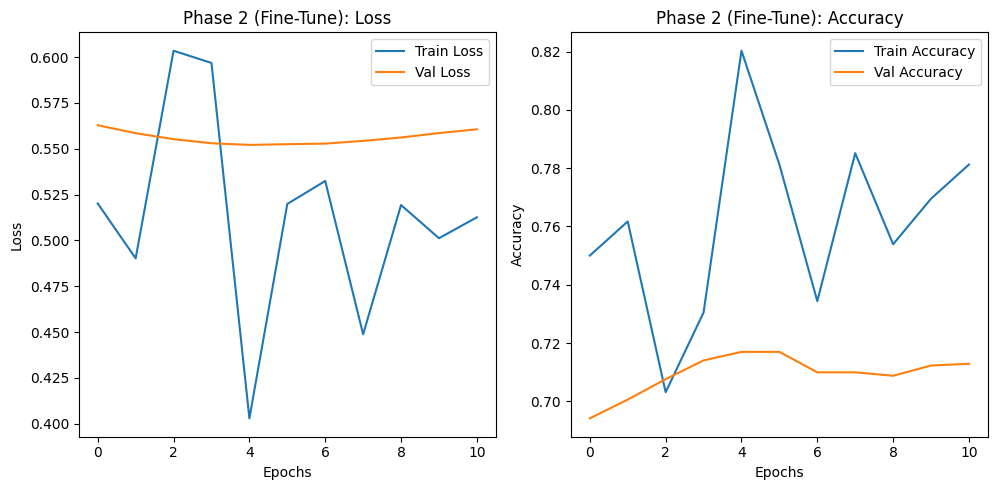

416/416 ━━━━━━━━━━━━━━━━━━━━ 58s 138ms/step - accuracy: 0.5726 - loss: 0.7250
Fine-Tuned Model Test Set Evaluation (Overall Metrics):
loss: 0.8059
compile_metrics: 0.4912
416/416 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step

Classification Report Test Set:
              precision    recall  f1-score   support

   spoof (0)       0.96      0.46      0.62     12008
 genuine (1)       0.14      0.82      0.24      1298

    accuracy                           0.49     13306
   macro avg       0.55      0.64      0.43     13306
weighted avg       0.88      0.49      0.58     13306



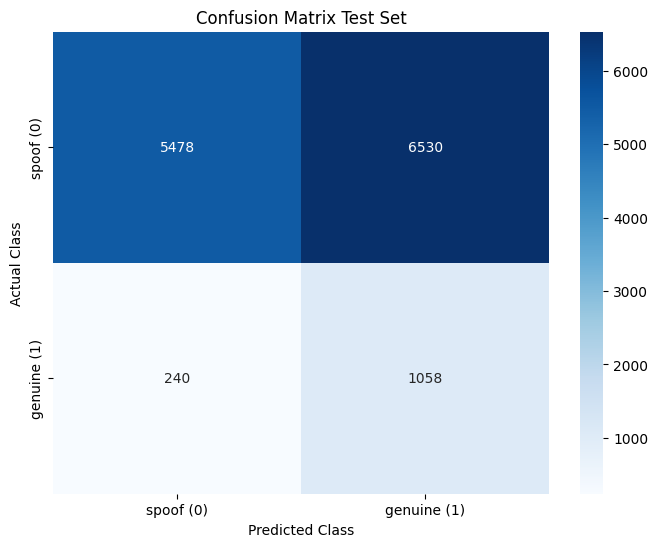

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step
              precision    recall  f1-score   support

   spoof (0)       0.76      0.99      0.86      1507
 genuine (1)       0.99      0.69      0.81      1507

    accuracy                           0.84      3014
   macro avg       0.88      0.84      0.84      3014
weighted avg       0.88      0.84      0.84      3014



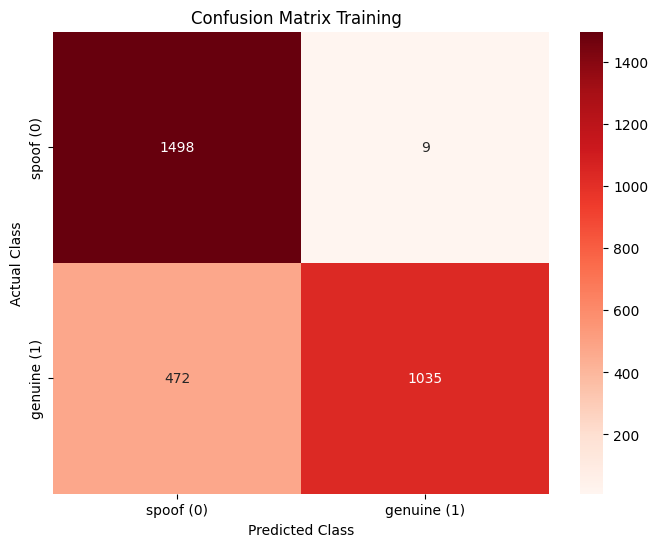

In [10]:

# Training History for Phase 2 
if 'history_phase2' in locals() and history_phase2 is not None:

    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history_phase2.history['loss'], label='Train Loss')
    plt.plot(history_phase2.history['val_loss'], label='Val Loss')
    plt.title('Phase 2 (Fine-Tune): Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history_phase2.history['accuracy'], label='Train Accuracy')
    plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy')
    plt.title('Phase 2 (Fine-Tune): Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
        
    plt.tight_layout()
    plt.show()


# Evaluate Fine-Tuned Model 
results_phase2_test = model.evaluate(
    [X_test_spec, X_test_mfcc_img], y_test,
    batch_size=BATCH_SIZE, 
    verbose=1
)


print("Fine-Tuned Model Test Set Evaluation (Overall Metrics):")
if hasattr(model, 'metrics_names'):
    for name, value in zip(model.metrics_names, results_phase2_test):
        print(f"{name}: {value:.4f}")
        


y_pred_probs_test_fine_tuned = model.predict([X_test_spec, X_test_mfcc_img], batch_size=BATCH_SIZE)
y_pred_classes_test_fine_tuned = (y_pred_probs_test_fine_tuned > 0.5).astype(int).flatten()
y_test_flat = y_test.flatten() if y_test.ndim > 1 else y_test

target_names = ['spoof (0)', 'genuine (1)']
print("\nClassification Report Test Set:")
print(classification_report(y_test_flat, y_pred_classes_test_fine_tuned, target_names=target_names))

cm_test_fine_tuned = confusion_matrix(y_test_flat, y_pred_classes_test_fine_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_fine_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


# Classification SummaryTRAINING SET 
y_pred_probs_train_fine_tuned = model.predict([X_train_spec, X_train_mfcc_img], batch_size=BATCH_SIZE)
y_pred_classes_train_fine_tuned = (y_pred_probs_train_fine_tuned > 0.5).astype(int).flatten()
y_train_flat = y_train.flatten() if y_train.ndim > 1 else y_train 


print(classification_report(y_train_flat, y_pred_classes_train_fine_tuned, target_names=target_names))
cm_train_fine_tuned = confusion_matrix(y_train_flat, y_pred_classes_train_fine_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_fine_tuned, annot=True, fmt='d', cmap='Reds', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Training  ')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()